## COMP47590 Advanced Machine Learning Lab Two
## Roll your Own Estimator - TemplateMatch

**TemplateMatch** only works for continuous descriptive features and categorical target features. TemplateMatch should work very simply as follows:

* **Training**: For each target feature level calculate the average value of all descriptive features for instances that have that target level. Store these average vectors as templates for each target level.
* **Prediction**: When a new prediction needs to be made compare the descriptive feature values of the new query instance to each template and return the target feature level that belongs to the template that is cloesest (based on Euclidean distance) to the query case.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn import metrics
from sklearn.datasets import load_iris

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Define the EducatedGuessClassifier Class

To build a scikit-learn classifier we extend from the **BaseEstimator** and **ClassifierMixin** classes and implement the **init**, **fit**, **predict**, and **predict_proba** methods.

In [3]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class TemplateMatchClassifier(BaseEstimator, ClassifierMixin):
    """TemplateMatch only works for continuous descriptive features and categorical target features.  
        - Training: For each target feature level calculate the average value of all descriptive features for instances that have that target level. Store these average vectors as templates for each target level.
        - Prediction: When a new prediction needs to be made compare the descriptive feature values of the new query instance to each template and return the target feature level that belongs to the template that is cloesest (based on Euclidean distance) to the query case. 

    Parameters
    ----------
    distance_metric string, optional (default = Euclidean)
        Whether or not a little bit of noise should be added to the distribution.

    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The class labels (single output problem).
    averagefeature_: dict
        A dictionary of the average value of all descriptive features for each class.
        
    Notes
    -----
    

    See also
    --------
    
    ----------
    
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = TemplateMatchClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    
    # Constructor for the classifier object
    def __init__(self, distance_metric = 'euclidean', random_state=None):
        self.distance_metric = distance_metric
        self.random_state = random_state

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build an educated guess classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like or sparse matrix, shape = [n_samples, n_features]
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """
        
        # change instance from array to 2D matrix
        #X = np.asmatrix(X)      
        #y = np.array(y)       
            
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Set up the random number generator to be used to generate 
        # predictions - this follows reccommended scikitlearn pattern
        # https://scikit-learn.org/stable/developers/develop.html#coding-guidelines
        self.random_state_ = check_random_state(self.random_state)
        
        # Count the number of occurrences of each class in the target vector (uses numpy unique function that returns a list of unique values and their counts)
        unique, counts = np.unique(y, return_counts=True)
        
        # Store the classes seen during fit
        self.classes_ = unique
        
        self.averagefeature_ = {}
        self.average_matrix_ = []
        
        for i in self.classes_:
            # extract index of each target feature
            idx = np.where(y == i)
            tmp = X[idx]
            # Create a new dictionary of classes and their mean values of features
            self.averagefeature_[i] = np.mean(tmp, axis=0)
            # Store the average values to a matrix
            self.average_matrix_.append(np.squeeze(np.asarray(self.averagefeature_[i])).tolist())
        
        # return the numpy matrix
        self.average_matrix_ = np.asarray(self.average_matrix_)
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the averagefeature_ dictionary has been set up
        check_is_fitted(self, ['averagefeature_'])
        
        # change instance from array to 2D matrix
        #X = np.asmatrix(X)             

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        # Initialise an empty list to store the predictions made
        predictions = list()
        
        # initialise the distance metric
        if self.distance_metric == 'mahalanobis':
            dist = metrics.DistanceMetric.get_metric(self.distance_metric, V = np.cov(X.T))
        else:
            dist = metrics.DistanceMetric.get_metric(self.distance_metric)
                            
        # Iterate through the query instances in the query dataset 
        for instance in X: 
            # change instance from array to 2D matrix
            instance = np.asmatrix(instance)  
        
            # compute the distance between instance and the template
            ins_distance = dist.pairwise(self.average_matrix_, instance).ravel()
            
            # find the shortest distance
            idx_min_dist = np.argmin(ins_distance)
            
            pred = self.classes_[idx_min_dist]
            
            predictions.append(pred)
            
        return np.array(predictions)

### Load MNIST Fashion Data

In [4]:
training_dataset_filename = "fashion-mnist_train.csv"
target_feature_name = "label"
classes = {0: "t-shirt", 1:"trouser", 2:"pullover", 3:"dress", 4:"coat", 
           5:"sandal", 6:"shirt", 7:"sneaker", 8:"bag", 9:"ankle boot"}
display_labels = ["t-shirt", "trouser", "pullover", "dress", "coat", 
                  "sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [5]:
training_data = pd.read_csv(training_dataset_filename)
print(training_data.shape)

(60000, 785)


In [6]:
display(training_data.head())
display(training_data.tail())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Partition Dataset

In [7]:
X = training_data.iloc[:, 1:]  # exclude the target label
y = training_data[target_feature_name]

Split the MNIST fashion training dataset into a training set and validation set (using 70:30 split).

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    shuffle = True, 
    stratify = y, 
    train_size = 0.7)

In [9]:
X_train = np.asmatrix(X_train)
X_valid = np.asmatrix(X_valid)
y_train = np.asarray(y_train)
y_valid = np.asarray(y_valid)

### Evaluate the TemplateMatch on MNIST Fashion dataset.

Set up some dictionaries to store simple model performance comparions

In [10]:
model_valid_accuracy_comparisons = dict()

In [11]:
# initialse the TemplateMatch algorithm
tm_classifier = TemplateMatchClassifier()

In [12]:
tm_classifier = tm_classifier.fit(X_train, y_train)

In [13]:
# Make a set of predictions for the validation data
y_val_pred = tm_classifier.predict(X_valid)

In [14]:
y_val_pred

array([8, 1, 2, ..., 4, 7, 3])

In [15]:
# Print performance details
val_accuracy = metrics.accuracy_score(y_valid, y_val_pred)
print("Accuracy: " +  str(val_accuracy))
print(metrics.classification_report(y_valid, y_val_pred))

Accuracy: 0.6886111111111111
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1800
           1       0.97      0.89      0.93      1800
           2       0.57      0.47      0.51      1800
           3       0.69      0.80      0.74      1800
           4       0.54      0.58      0.56      1800
           5       0.49      0.78      0.60      1800
           6       0.35      0.21      0.26      1800
           7       0.77      0.81      0.79      1800
           8       0.95      0.77      0.85      1800
           9       0.87      0.88      0.87      1800

    accuracy                           0.69     18000
   macro avg       0.69      0.69      0.68     18000
weighted avg       0.69      0.69      0.68     18000



Confusion Matrix


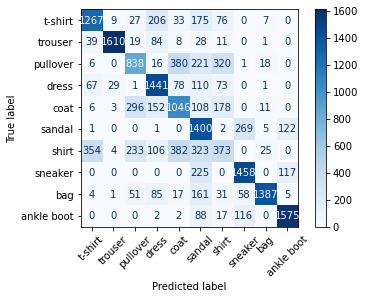

In [16]:
# Print confusion matrix
print("Confusion Matrix")
metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_val_pred, 
                                                cmap = 'Blues', 
                                                display_labels = display_labels, 
                                                xticks_rotation = 45)

In [17]:
model_valid_accuracy_comparisons["euclidean"] = val_accuracy

### Experiment with Alternative Distance Metrics

Metrics intended for real-valued vector spaces:

* “euclidean” - EuclideanDistance
* “manhattan” - ManhattanDistance
* “chebyshev” - ChebyshevDistance
* “minkowski” - MinkowskiDistance
* “wminkowski” - WMinkowskiDistance
* “seuclidean” - SEuclideanDistance
* “mahalanobis” - MahalanobisDistance

**Manhattan Distance**

In [18]:
# initialse the TemplateMatch algorithm with Manhattan Distance
tm_manh_classifier = TemplateMatchClassifier(distance_metric = 'manhattan')
tm_manh_classifier = tm_manh_classifier.fit(X_train, y_train)

In [19]:
# Make a set of predictions for the validation data
y_val_pred = tm_manh_classifier.predict(X_valid)

In [20]:
# Print performance details
val_accuracy = metrics.accuracy_score(y_valid, y_val_pred)
print("Accuracy: " +  str(val_accuracy))
print(metrics.classification_report(y_valid, y_val_pred))

Accuracy: 0.614
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1800
           1       0.77      0.94      0.85      1800
           2       0.63      0.25      0.35      1800
           3       0.57      0.69      0.62      1800
           4       0.43      0.65      0.52      1800
           5       0.42      0.54      0.47      1800
           6       0.36      0.17      0.23      1800
           7       0.58      0.89      0.70      1800
           8       0.97      0.54      0.69      1800
           9       0.86      0.82      0.84      1800

    accuracy                           0.61     18000
   macro avg       0.64      0.61      0.60     18000
weighted avg       0.64      0.61      0.60     18000



Confusion Matrix


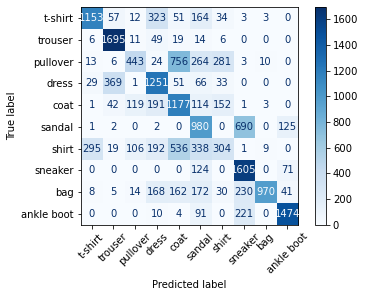

In [21]:
# Print confusion matrix
print("Confusion Matrix")
metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_val_pred, 
                                                cmap = 'Blues', 
                                                display_labels = display_labels, 
                                                xticks_rotation = 45)

In [22]:
model_valid_accuracy_comparisons["manhattan"] = val_accuracy

**Chebyshev Distance**

In [23]:
# initialse the TemplateMatch algorithm with Chebyshev Distance
tm_cheb_classifier = TemplateMatchClassifier(distance_metric = 'chebyshev')
tm_cheb_classifier = tm_cheb_classifier.fit(X_train, y_train)

In [24]:
# Make a set of predictions for the validation data
y_val_pred = tm_cheb_classifier.predict(X_valid)

In [25]:
# Print performance details
val_accuracy = metrics.accuracy_score(y_valid, y_val_pred)
print("Accuracy: " +  str(val_accuracy))
print(metrics.classification_report(y_valid, y_val_pred))

Accuracy: 0.46494444444444444
              precision    recall  f1-score   support

           0       0.45      0.65      0.54      1800
           1       0.99      0.41      0.57      1800
           2       0.44      0.53      0.48      1800
           3       0.76      0.24      0.36      1800
           4       0.55      0.13      0.22      1800
           5       0.72      0.18      0.28      1800
           6       0.20      0.54      0.29      1800
           7       0.87      0.51      0.64      1800
           8       0.39      0.80      0.53      1800
           9       0.79      0.66      0.72      1800

    accuracy                           0.46     18000
   macro avg       0.62      0.46      0.46     18000
weighted avg       0.62      0.46      0.46     18000



Confusion Matrix


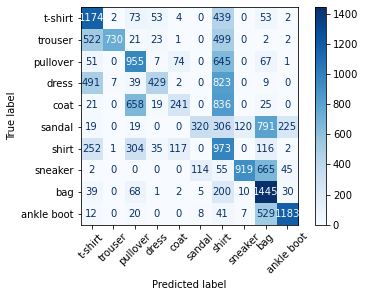

In [26]:
# Print confusion matrix
print("Confusion Matrix")
metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_val_pred, 
                                                cmap = 'Blues', 
                                                display_labels = display_labels, 
                                                xticks_rotation = 45)

In [27]:
model_valid_accuracy_comparisons["chebyshev"] = val_accuracy

**Mahalanobis Distance**

In [28]:
# initialse the TemplateMatch algorithm with Mahalanobis Distance
tm_maha_classifier = TemplateMatchClassifier(distance_metric = 'mahalanobis')
tm_maha_classifier = tm_maha_classifier.fit(X_train, y_train)

In [29]:
# Make a set of predictions for the validation data
y_val_pred = tm_maha_classifier.predict(X_valid)

In [30]:
# Print performance details
val_accuracy = metrics.accuracy_score(y_valid, y_val_pred)
print("Accuracy: " +  str(val_accuracy))
print(metrics.classification_report(y_valid, y_val_pred))

Accuracy: 0.7996111111111112
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1800
           1       1.00      0.93      0.96      1800
           2       0.71      0.70      0.71      1800
           3       0.80      0.81      0.81      1800
           4       0.69      0.75      0.72      1800
           5       0.81      0.86      0.83      1800
           6       0.54      0.59      0.56      1800
           7       0.88      0.87      0.87      1800
           8       0.95      0.84      0.89      1800
           9       0.91      0.90      0.90      1800

    accuracy                           0.80     18000
   macro avg       0.81      0.80      0.80     18000
weighted avg       0.81      0.80      0.80     18000



Confusion Matrix


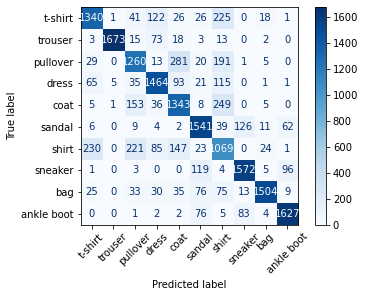

In [31]:
# Print confusion matrix
print("Confusion Matrix")
metrics.ConfusionMatrixDisplay.from_predictions(y_valid, y_val_pred, 
                                                cmap = 'Blues', 
                                                display_labels = display_labels, 
                                                xticks_rotation = 45)

In [32]:
model_valid_accuracy_comparisons["mahalanobis"] = val_accuracy

### Evaluate the Performance

In [33]:
display(model_valid_accuracy_comparisons)

{'euclidean': 0.6886111111111111,
 'manhattan': 0.614,
 'chebyshev': 0.46494444444444444,
 'mahalanobis': 0.7996111111111112}

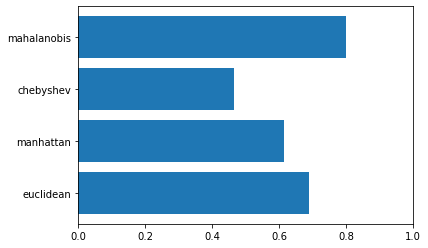

In [34]:
plt.xlim(0, 1.0)

_ = plt.barh(range(len(model_valid_accuracy_comparisons)), 
             list(model_valid_accuracy_comparisons.values()), 
             align='center')

_= plt.yticks(range(len(model_valid_accuracy_comparisons)), 
              list(model_valid_accuracy_comparisons.keys()))

The plot indicates that the Mahalanobis distance metric achieved the highest accuracy on MNIST fashion dataset.

### Explored TemplateMatch Using the GridSearchCV

In [37]:
# Set up the parameter grid to seaerch
param_grid ={
    'distance_metric': ['euclidean', 'manhattan', 'chebyshev', 'mahalanobis']
}
cv_folds = 5

In [39]:
# Perform the search
my_tuned_TemplateMatch = GridSearchCV(TemplateMatchClassifier(), 
                                                      param_grid, cv = cv_folds, verbose = 2, 
                                                      return_train_score = True, n_jobs = -1)

In [41]:
X = np.asmatrix(X)
y = np.asarray(y)

In [42]:
my_tuned_TemplateMatch.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-

[CV] END ..........................distance_metric=euclidean; total time=   0.4s
[CV] END ..........................distance_metric=euclidean; total time=   0.4s
[CV] END ..........................distance_metric=euclidean; total time=   0.4s
[CV] END ..........................distance_metric=manhattan; total time=   0.4s


GridSearchCV(cv=5, estimator=TemplateMatchClassifier(), n_jobs=-1,
             param_grid={'distance_metric': ['euclidean', 'manhattan',
                                             'chebyshev', 'mahalanobis']},
             return_train_score=True, verbose=2)

In [44]:
# Print details
print("Best parameters set found on development set:")
print(my_tuned_TemplateMatch.best_params_)
#model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_TemplateMatch.best_score_)
#model_accuracy_comparisons["Tuned kNN"] = my_tuned_model.best_score_

Best parameters set found on development set:
{'distance_metric': 'mahalanobis'}
0.7862666666666667
